# AgCaP code #2
<br>

**Conceptualization, Methodology, Code:** [Davide Mazzoni](https://github.com/orgs/SEforALL-IEAP/people/davidemazzoni2) <br>  **Supervision, Review and Advisory support:** xx<br> **Funding:** SEforALL

--------------------------
## Discription of the code
This code:
- takes as input the enhanced settlement layer with all the relevant data extracted into it
- performs the required transformations
- calculates the main composite indices required for the analysis
- visualizes the results
- allows to perform a multi-criteria analysis for customized site selection and ranking processes

Note: This version takes enhanced Mozambique settlement layer with extracted attributes prepared manually in QGIS. A future verison will take the output of the main AgCAP code developed by Alexandros Korkovelos, which is meant to replace the manual QGIS data manipulation and extraction.

## Importing necessary packages

In [1]:
import geopandas as gpd
import pandas as pd
#import leafmap.kepler as leafmap
#import geemap
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
from keplergl import KeplerGl
import rasterstats
import ipywidgets as widgets
import folium
import rasterio
import os
#import panel as pn
#from bokeh.models.formatters import PrintfTickFormatter

In [2]:
ROOT_DIR = os.path.abspath(os.getcwd())
in_path = ROOT_DIR + "\\" + 'GIS_data'
workspace = ROOT_DIR + "\\" + "Output"

## Read and prepare the settlements
Read the enhanced settlements geopackage previously prepared, containing all the settlement polygons in the Country and its extracted attributes

In [4]:
#Read the layer already prepared by extracting all the relevant data into the clusters
# Define path and name of the file
settles_path = in_path + "\\" + "Settlements"
settles_name = "pop_clusters_enhanced_v2_Mopeia.gpkg"

## Read settlements as gdf
settl = gpd.read_file(settles_path + "\\" + settles_name)

#settles_name = "Mozambique_Settlement_Extents_Version_02.geojson"
#settl_path=r"c:/Users/david/OneDrive - Sustainable Energy for All/Cooling_module_analysis/Data/population_clusters_enhanced_v2.gpkg"
#settl=gpd.read_file(settl_path)

In [5]:
#Transform polygons into centroids to speed up the computational time. The final results can then be joined back to the polygon layer
#settl.drop(columns=['_max','_air_2majority','_air_2mean'],inplace=True)
settl_point=settl.copy()
settl_point["geometry"]=settl_point["geometry"].centroid
settl_point

,country,iso,bld_count,dou_level1,dou_level2,pcode,area_m2,SHAPE_Le_1,SHAPE_Area,croplnd_area_m2,...,dist_coast_km,pop_20km_buffer,travel_maj_city_200k,travel_to_airports,travel_to_railw,travel_to_capital,_air_2mean,_air_2majority,_max,geometry
0,Mozambique,MOZ,251-1000,Rural,Low Density Rural,MZ1117000006,5.115072e+05,0.051805,0.000044,5575800,...,126.006772,76231.820508,2.614064,0.433477,0.432984,16.216954,0.433477,0.425144,0.441811,POINT (762729.368 -1974892.054)
1,Mozambique,MOZ,101-250,Rural,Low Density Rural,MZ1013000014,1.858669e+05,0.026449,0.000016,309700,...,162.838302,113651.277059,3.125641,0.981940,0.899906,16.765417,0.981940,0.966407,1.024740,POINT (739546.403 -1945448.298)
2,Mozambique,MOZ,101-250,Rural,Low Density Rural,MZ1117000010,2.688507e+05,0.030768,0.000023,2892700,...,130.119983,82289.103700,2.514606,0.334019,0.333526,16.117496,0.334019,0.308723,0.359315,POINT (758974.050 -1972101.718)
3,Mozambique,MOZ,101-250,Rural,Rural,MZ1013000020,3.589820e+05,0.066593,0.000031,473700,...,161.600085,108462.398335,3.002539,0.858837,0.820851,16.642314,0.858837,0.856766,0.860908,POINT (742564.646 -1943802.974)
4,Mozambique,MOZ,51-100,Rural,Rural,MZ1117000015,1.082059e+05,0.014568,0.000009,941100,...,135.416945,93891.293752,2.338395,0.202959,0.202466,15.986435,0.202959,0.141631,0.219413,POINT (756138.451 -1967637.430)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,Mozambique,MOZ,51-100,Rural,Low Density Rural,MZ1117000101,2.703001e+05,0.041874,0.000023,3312400,...,7.321713,55313.333875,1.634866,1.645507,2.792370,19.819003,1.645507,1.496799,1.722687,POINT (885688.286 -2012533.773)
289,Mozambique,MOZ,251-1000,Rural,Rural,MZ1108400243,1.694012e+06,0.314089,0.000145,2318800,...,12.072151,88808.320101,0.801361,0.812002,2.892694,18.985498,0.812002,0.816969,0.857827,POINT (892405.373 -2000896.321)
290,Mozambique,MOZ,251-1000,Rural,Low Density Rural,MZ1108000009,1.067589e+06,0.154458,0.000091,1336700,...,5.717539,99257.548007,1.125950,1.136591,2.751684,19.310087,1.136591,1.057522,1.200200,POINT (897750.116 -2009777.866)
291,Mozambique,MOZ,101-250,Rural,Low Density Rural,MZ1122000017,3.982920e+05,0.066480,0.000034,1265800,...,30.001722,115396.572518,2.250795,2.360246,3.459011,19.242981,2.360246,2.318824,2.401667,POINT (888529.295 -1958156.998)


In [6]:
settl_point.describe()

,area_m2,SHAPE_Le_1,SHAPE_Area,croplnd_area_m2,croplnd_area_perc,influence_area_m2,relative_wealth,travel_ports_FAO,travel_cities_20k_FAO,food_insecur_class,...,mrkt_accs_ports_mean,dist_coast_km,pop_20km_buffer,travel_maj_city_200k,travel_to_airports,travel_to_railw,travel_to_capital,_air_2mean,_air_2majority,_max
count,2.930000e+02,293.000000,293.000000,2.930000e+02,293.000000,2.930000e+02,291.000000,293.000000,293.000000,293.000000,...,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000
mean,5.016262e+05,0.070680,0.000043,2.513509e+06,0.122914,4.296097e+07,-0.386491,4.071021,1.619134,2.102389,...,3.850452,88.248493,66755.533003,2.474464,0.976961,1.339086,17.523469,0.976961,0.945263,1.026114
std,9.265167e+05,0.059378,0.000079,3.122099e+06,0.101154,6.892395e+07,0.227741,1.750349,1.041304,0.303678,...,1.592189,46.187798,33950.700198,0.864771,0.764201,1.019900,1.176775,0.764201,0.751855,0.776450
min,8.814144e+04,0.014568,0.000008,7.770000e+04,0.002237,1.207705e+06,-0.866000,0.648033,0.087266,2.000000,...,0.565002,1.535561,9642.388854,0.618296,0.036017,0.039353,15.767397,0.036017,0.010000,0.052078
25%,1.978484e+05,0.037738,0.000017,9.126000e+05,0.036242,1.006366e+07,-0.525000,3.062146,0.965708,2.000000,...,2.848208,58.736876,35265.585053,1.831881,0.460445,0.556169,16.546369,0.460445,0.444025,0.521822
50%,2.828587e+05,0.051154,0.000024,1.797000e+06,0.103269,1.788941e+07,-0.413000,4.115291,1.395282,2.000000,...,3.939063,88.210711,64489.091952,2.622003,0.738782,0.992143,17.376332,0.738782,0.707747,0.782747
75%,4.927200e+05,0.077457,0.000042,3.119900e+06,0.183056,4.653227e+07,-0.294000,5.044874,1.925763,2.000000,...,4.802315,128.666666,93797.270857,3.141583,1.228798,1.874195,18.194366,1.228798,1.200036,1.274812
max,1.260350e+07,0.458991,0.001074,3.149260e+07,0.504654,4.297128e+08,0.639000,10.593932,7.095768,3.000000,...,9.887290,165.659740,168906.443404,4.183025,4.211355,4.716570,22.367162,4.211355,4.113150,4.329816


In [7]:
settl_point.columns

Index(['country', 'iso', 'bld_count', 'dou_level1', 'dou_level2', 'pcode',
       'area_m2', 'SHAPE_Le_1', 'SHAPE_Area', 'croplnd_area_m2',
       'croplnd_area_perc', 'influence_area_m2', 'relative_wealth',
       'livelihood_zone', 'travel_ports_FAO', 'travel_cities_20k_FAO',
       'food_insecur_class', 'nightlights_mean', 'nightlights_min',
       'nightlights_max', 'electrif_status_nightlights', 'pop',
       'fishing_activity_sea', 'inland_water_area_3km_ha',
       'fishing_activity_inland', 'cooling_deg_days_4Cdeg',
       'croplnd_area_GLADM19_ha', 'croplnd_area_GLADM19_perc',
       'croplnd_3km_buff_ha_count', 'croplnd_3km_buff_ha_sum',
       'croplnd_3km_buff_perc', 'households',
       'food_insec_p3_plus_C_population_percentage',
       'food_insec_p3_plus_C_population', 'mrkt_accs_cities_20kmean',
       'mrkt_accs_ports_mean', 'dist_coast_km', 'pop_20km_buffer',
       'travel_maj_city_200k', 'travel_to_airports', 'travel_to_railw',
       'travel_to_capital', '_air_2m

In [8]:
#Drop unnecessary columns
settl_point.drop(columns=['SHAPE_Le_1', 'SHAPE_Area','croplnd_area_m2','croplnd_area_perc','travel_ports_FAO', 'travel_cities_20k_FAO','_air_2mean', '_air_2majority', '_max'],inplace=True)

In [9]:
settl_point.columns

Index(['country', 'iso', 'bld_count', 'dou_level1', 'dou_level2', 'pcode',
       'area_m2', 'influence_area_m2', 'relative_wealth', 'livelihood_zone',
       'food_insecur_class', 'nightlights_mean', 'nightlights_min',
       'nightlights_max', 'electrif_status_nightlights', 'pop',
       'fishing_activity_sea', 'inland_water_area_3km_ha',
       'fishing_activity_inland', 'cooling_deg_days_4Cdeg',
       'croplnd_area_GLADM19_ha', 'croplnd_area_GLADM19_perc',
       'croplnd_3km_buff_ha_count', 'croplnd_3km_buff_ha_sum',
       'croplnd_3km_buff_perc', 'households',
       'food_insec_p3_plus_C_population_percentage',
       'food_insec_p3_plus_C_population', 'mrkt_accs_cities_20kmean',
       'mrkt_accs_ports_mean', 'dist_coast_km', 'pop_20km_buffer',
       'travel_maj_city_200k', 'travel_to_airports', 'travel_to_railw',
       'travel_to_capital', 'geometry'],
      dtype='object')

In [10]:
# Define the column names and descriptions
data_dict = {
    'Column Name': ['country', 'iso', 'bld_count', 'dou_level1', 'dou_level2', 'pcode',
                    'area_m2', 'influence_area_m2', 'relative_wealth',
                    'livelihood_zone',
                    'food_insecur_class', 'nightlights_mean', 'nightlights_min',
                    'nightlights_max', 'electrif_status_nightlights', 'pop',
                    'fishing_activity_sea', 'inland_water_area_3km_ha',
                    'fishing_activity_inland', 'cooling_deg_days_4Cdeg',
                    'croplnd_area_GLADM19_ha', 'croplnd_area_GLADM19_perc',
                    'croplnd_3km_buff_ha_count', 'croplnd_3km_buff_ha_sum',
                    'croplnd_3km_buff_perc', 'households',
                    'food_insec_p3_plus_C_population_percentage',
                    'food_insec_p3_plus_C_population', 'mrkt_accs_cities_20kmean',
                    'mrkt_accs_ports_mean', 'dist_coast_km', 'pop_20km_buffer',
                    'travel_maj_city_200k', 'travel_to_airports', 'travel_to_railw',
                    'travel_to_capital',
                    'geometry'],
    'Description': ['Country name', 'ISO code of the country', 'Building count', 'Urbanicity level 1',
                    'Urbanicity level 2', 'Postal code', 'Settlement area in square meters',
                    'Voronoi polygon influence area in square meters',
                    'Relative wealth index', 'Livelihood zone',
                    'Food insecurity class', 'Mean nightlights value', 'Minimum nightlights value', 'Maximum nightlights value',
                    'Electrification status based on nightlights', 'Population', 'Marine fishing activity', 'Inland water area within 3km buffer, in hectares',
                    'Inland fishing activity', 'Cooling degree days at reference temperature of 4°C', 'Cropland area in hectares (GLADM 2019) within the voronoi influence area',
                    'Percentage of cropland area (GLADM 2019) within the voronoi influence area', 'Area of the polygon with a 3km buffer around the settlement', 'Sum of cropland within the 3km-buffered polygon',
                    'Percentage of cropland area within the 3km-buffered polygon', 'Number of households', 'Percentage of population with food insecurity (P3+ class)',
                    'Population with food insecurity (P3+ class)', 'Market access to closest city with population over 20,000 (FAO data)', 'Travel time to closest port (FAO data)',
                    'Distance to nearest coastline in kilometers', 'Population within 20km buffer', 'Travel time to closest major city with population over 200,000',
                    'Travel time to closest airport', 'Travel time to closest railway station', 'Travel time to capital city', 'Geometric shape of the area']
}

# Create a DataFrame from the data dictionary
data_dict = pd.DataFrame(data_dict)

# Print the DataFrame
data_dict

,Column Name,Description
0,country,Country name
1,iso,ISO code of the country
2,bld_count,Building count
3,dou_level1,Urbanicity level 1
4,dou_level2,Urbanicity level 2
5,pcode,Postal code
6,area_m2,Settlement area in square meters
7,influence_area_m2,Voronoi polygon influence area in square meters
8,relative_wealth,Relative wealth index
9,livelihood_zone,Livelihood zone


## Visualize the settlements
Inspect the settlement points on an interactive map

In [16]:

#settl_point.explore(
#    marker_kwds=dict(radius=2, fill=True),
#    style_kwds=dict(weight=0.5,opacity=0.2,fillOpacity=0.3),
#    tooltip='pop',
#    popup=True,  # show all values in popup (on click)
#    tiles="CartoDB Positron",  # use "CartoDB positron" tiles
#    tooltip_kwds={
#        'style': 'font-size: 8px;'
#    },
#    popup_kwds={
#        'style': 'font-size: 10px;'
#    },
#    height=1000
#)

## Compute the farming activity index
1. Compute the farming activity, which is a proxy for farming activity based on:
- Farming volume: Cropland area within each settlement's influence area (Voronoi polygon)
- Farming density: Percentage of each settlement's influence area (Voronoi polygon) occupied by crops

2. Normalize the index using min-max scaling

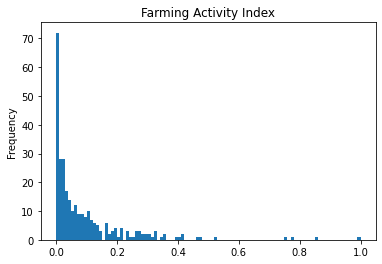

In [17]:
#Calculating farming activity index based on surrounding cropland area and cropland area percentage
w_croplnd_area_ha=0.5
w_croplnd_area_perc=0.5
settl_point['farming_activity']= (
    (settl_point['croplnd_area_GLADM19_ha'] - settl_point['croplnd_area_GLADM19_ha'].min())/(settl_point['croplnd_area_GLADM19_ha'].max() - settl_point['croplnd_area_GLADM19_ha'].min())*w_croplnd_area_ha
    + (settl_point['croplnd_area_GLADM19_perc'] - settl_point['croplnd_area_GLADM19_perc'].min())/(settl_point['croplnd_area_GLADM19_perc'].max() - settl_point['croplnd_area_GLADM19_perc'].min())*w_croplnd_area_perc
)
#normalize
scaler = MinMaxScaler()
settl_point['farming_activity_n']= scaler.fit_transform(settl_point[['farming_activity']])
settl_point['farming_activity_n'].plot.hist(bins=100, title='Farming Activity Index')

3. Reduce skewness to obtain a more uniform distribution

count    293.000000
mean       0.450619
std        0.197054
min        0.000000
25%        0.317853
50%        0.448421
75%        0.580337
max        1.000000
Name: farming_activity_n, dtype: float64

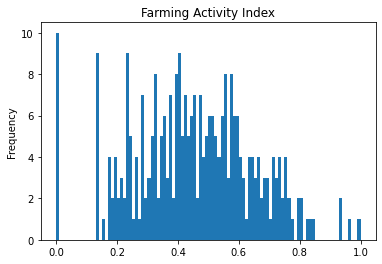

In [18]:

#reduce skeweness
settl_point['farming_activity_n']=np.power((settl_point['farming_activity_n']),1/4)

settl_point['farming_activity_n'].plot.hist(bins=100, title='Farming Activity Index')
# Create a 3D scatter plot
# fig = px.scatter_3d(settl_point, x='croplnd_area_GLADM19_perc', y='croplnd_area_GLADM19_ha', z='farming_activity_n')
# fig.show()
# settl_point.plot.scatter(y='farming_activity_n', x='croplnd_area_GLADM19_perc')

#((settl_point['croplnd_area_GLADM19_ha'] - settl_point['croplnd_area_GLADM19_ha'].min())/(settl_point['croplnd_area_GLADM19_ha'].max() - settl_point['croplnd_area_GLADM19_ha'].min())).plot.hist(bins=100)
settl_point['farming_activity_n'].describe()

4. Visualize the farming activity index

In [ ]:
#top_farming_act=settl_point.sort_values(by='farming_activity',ascending=False)#.head(100)
top_farming_act=settl_point.loc[settl_point['farming_activity_n'] > 0.75]
m=top_farming_act.explore(
    column="farming_activity_n",
    marker_kwds=dict(radius=2, fill=True),  # make marker radius 10px with fill
    style_kwds=dict(weight=0.5,opacity=0.2,fillOpacity=0.3),  # make line thickness 1px
    tooltip="farming_activity_n",
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB Positron",  # use "CartoDB positron" tiles
    cmap="viridis",  # use "Set1" matplotlib colormap
    labels=["Farming activity index"],
    legend_kwds=dict(caption='Farming activity index'),
    location=[-15.92071047059695, 35.992526466359394],
    zoom_start=7,
    #style_kwds=dict(color="black"),  # use black outline
        tooltip_kwds={
        'style': 'font-size: 8px;'
    },
    popup_kwds={
        'style': 'font-size: 10px;'
    },
    height=1000
)
m

## Compute the market accessibility index
Compute the market accessibility, which is a proxy for the possibility to trade or export agricultural products based on a weighted average of:
- travel time to the capital city (potential for export and national distribution)
- travel time to railway stations (potential for export and national distribution)
- travel time to airports (potential for export and national distribution)
- travel time to major cities (potential for sales in fresh markets and national distribution)
- population within 20 km radius (potential for sales in fresh markets)
- farming density: Percentage of each settlement's influence area (Voronoi polygon) occupied by crops
- travel time to ports (not yet implemented)

1. Normalize the accessibility parameters using min-max scaling

In [19]:
#Normalization of accessibility parameters
""" scaler = MinMaxScaler()
settl_point['travel_to_capital_n'] = scaler.fit_transform(settl_point[['travel_to_capital']])
settl_point['travel_to_railw_n'] = scaler.fit_transform(settl_point[['travel_to_railw']])
settl_point['travel_to_airports_n'] = scaler.fit_transform(settl_point[['travel_to_airports']])
settl_point['travel_maj_city_200k_n'] = scaler.fit_transform(settl_point[['travel_maj_city_200k']])
settl_point['pop_20km_buffer_n'] = scaler.fit_transform(settl_point[['pop_20km_buffer']])
settl_point """


settl_point['travel_to_capital_n'] = (settl_point['travel_to_capital'].max()-settl_point['travel_to_capital'])/(settl_point['travel_to_capital'].max()-settl_point['travel_to_capital'].min())
settl_point['travel_to_railw_n'] = (settl_point['travel_to_railw'].max()-settl_point['travel_to_railw'])/(settl_point['travel_to_railw'].max()-settl_point['travel_to_railw'].min())
settl_point['travel_to_airports_n'] = (settl_point['travel_to_airports'].max()-settl_point['travel_to_airports'])/(settl_point['travel_to_airports'].max()-settl_point['travel_to_airports'].min())
settl_point['travel_maj_city_200k_n'] = (settl_point['travel_maj_city_200k'].max()-settl_point['travel_maj_city_200k'])/(settl_point['travel_maj_city_200k'].max()-settl_point['travel_maj_city_200k'].min())
settl_point['pop_20km_buffer_n'] = (settl_point['pop_20km_buffer']-settl_point['pop_20km_buffer'].min())/(settl_point['pop_20km_buffer'].max()-settl_point['pop_20km_buffer'].min())
pd.set_option('display.max_columns', None)
settl_point

,country,iso,bld_count,dou_level1,dou_level2,pcode,area_m2,influence_area_m2,relative_wealth,livelihood_zone,food_insecur_class,nightlights_mean,nightlights_min,nightlights_max,electrif_status_nightlights,pop,fishing_activity_sea,inland_water_area_3km_ha,fishing_activity_inland,cooling_deg_days_4Cdeg,croplnd_area_GLADM19_ha,croplnd_area_GLADM19_perc,croplnd_3km_buff_ha_count,croplnd_3km_buff_ha_sum,croplnd_3km_buff_perc,households,food_insec_p3_plus_C_population_percentage,food_insec_p3_plus_C_population,mrkt_accs_cities_20kmean,mrkt_accs_ports_mean,dist_coast_km,pop_20km_buffer,travel_maj_city_200k,travel_to_airports,travel_to_railw,travel_to_capital,geometry,farming_activity,farming_activity_n,travel_to_capital_n,travel_to_railw_n,travel_to_airports_n,travel_maj_city_200k_n,pop_20km_buffer_n
0,Mozambique,MOZ,251-1000,Rural,Low Density Rural,MZ1117000006,5.115072e+05,23362135,-0.291,Zambezi Valley with Maize and Fishing,2,0.247986,0.240674,0.260118,unelectrified,487.220140,NaN,162.0,1.0,7888.503582,188,0.079,52656.0,3709.0,0.070,106,NaN,NaN,1.246469,3.823141,126.006772,76231.820508,2.614064,0.433477,0.432984,16.216954,POINT (762729.368 -1974892.054),0.104023,0.617848,0.931883,0.915841,0.904808,0.440135,0.418107
1,Mozambique,MOZ,101-250,Rural,Low Density Rural,MZ1013000014,1.858669e+05,3309985,-0.776,Northern Highland with Mixed Cropping,3,0.245200,0.238022,0.252378,unelectrified,289.826032,NaN,NaN,0.0,7966.726418,73,0.217,47159.0,17323.0,0.367,63,0.35,71488.0,1.792504,4.504655,162.838302,113651.277059,3.125641,0.981940,0.899906,16.765417,POINT (739546.403 -1945448.298),0.185279,0.713766,0.848779,0.816012,0.773450,0.296624,0.653059
2,Mozambique,MOZ,101-250,Rural,Low Density Rural,MZ1117000010,2.688507e+05,17228519,-0.301,Zambezi Valley with Maize and Fishing,2,0.307030,0.281491,0.331833,unelectrified,265.411716,NaN,594.0,1.0,7956.999722,129,0.074,47924.0,3537.0,0.074,58,NaN,NaN,1.506376,3.747247,130.119983,82289.103700,2.514606,0.334019,0.333526,16.117496,POINT (758974.050 -1972101.718),0.086768,0.590459,0.946953,0.937105,0.928628,0.468035,0.456140
3,Mozambique,MOZ,101-250,Rural,Rural,MZ1013000020,3.589820e+05,1805239,-0.582,Northern Highland with Mixed Cropping,3,0.239103,0.232825,0.242838,unelectrified,391.182986,NaN,0.0,0.0,7993.499861,75,0.409,52370.0,20839.0,0.398,85,0.35,71488.0,1.785529,4.489594,161.600085,108462.398335,3.002539,0.858837,0.820851,16.642314,POINT (742564.646 -1943802.974),0.335032,0.827696,0.867432,0.832914,0.802933,0.331157,0.620479
4,Mozambique,MOZ,51-100,Rural,Rural,MZ1117000015,1.082059e+05,3666636,0.639,Zambezi Valley with Maize and Fishing,2,0.935337,0.747816,2.281082,electrified,88.386992,NaN,87.0,1.0,7909.192306,33,0.089,42703.0,4732.0,0.111,19,NaN,NaN,1.765248,3.491973,135.416945,93891.293752,2.338395,0.202959,0.202466,15.986435,POINT (756138.451 -1967637.430),0.076683,0.572499,0.966811,0.965126,0.960017,0.517467,0.528989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,Mozambique,MOZ,51-100,Rural,Low Density Rural,MZ1117000101,2.703001e+05,105170379,-0.594,"Plains with Cassava, Rice, and Fishing",2,0.237068,0.227507,0.246533,unelectrified,248.538197,NaN,185.0,1.0,7738.000278,39,0.004,47602.0,269.0,0.006,54,NaN,NaN,2.704165,3.880227,7.321713,55313.333875,1.634866,1.645507,2.792370,19.819003,POINT (885688.286 -2012533.773),0.011946,0.359670,0.386098,0.411398,0.614525,0.714826,0.286762
289,Mozambique,MOZ,251-1000,Rural,Rural,MZ1108400243,1.694012e+06,75520668,-0.511,North-Central Coastal Fishing,2,0.233759,0.219577,0.250398,unelectrified,1299.802202,NaN,0.0,0.0,7701.500139,34,0.004,79141.0,773.0,0.010,283,NaN,NaN,1.239594,1.241974,12.072151,88808.320101,0.801361,0.812002,2.892694,18.985498,POINT (892405.373 -2000896.321),0.010813,0.350823,0.512392,0.389949,0.814150,0.948646,0.497073
290,Mozambique,MOZ,251-1000,Rural,Low Density Rural,MZ1108000009,1.067589e+06,88415

2. Assign weights, normalize weights, calculate weighted average, normalize the index

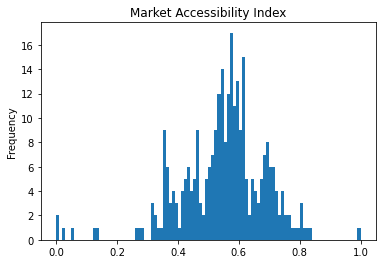

In [20]:
#Setting weights from 0 to 100
w_travel_to_capital=5
w_travel_to_railw=20
w_travel_to_air=50
w_travel_to_maj_city=100
w_pop20km=100

#Normalizing weights
weights=np.array([w_travel_to_capital, w_travel_to_railw, w_travel_to_air, w_travel_to_maj_city, w_pop20km])
total_weights = np.sum(weights)
w_travel_to_capital=w_travel_to_capital/total_weights
w_travel_to_railw=w_travel_to_railw/total_weights
w_travel_to_air=w_travel_to_air/total_weights
w_travel_to_maj_city=w_travel_to_maj_city/total_weights
w_pop20km=w_pop20km/total_weights

#Calculating accessibility indicator for farming activity, i.e. proxy for the ability to sell agricultural outputs
access_farm_index=(
    w_travel_to_capital*settl_point['travel_to_capital_n']+
    w_travel_to_railw*settl_point['travel_to_railw_n']+
    w_travel_to_air*settl_point['travel_to_airports_n']+
    w_travel_to_maj_city*settl_point['travel_maj_city_200k_n']+
    w_pop20km*settl_point['pop_20km_buffer_n']
)
settl_point['access_farm_index']=access_farm_index
#normalize access_farm_index
access_farm_index_n= (settl_point['access_farm_index'] - settl_point['access_farm_index'].min()) / (settl_point['access_farm_index'].max() - settl_point['access_farm_index'].min())

""" scaler = MinMaxScaler()
access_farm_index_n = scaler.fit_transform(settl_point['access_farm_index'].values.reshape(-1, 1)).flatten()
 """
settl_point['access_farm_index_n'] = access_farm_index_n
settl_point['access_farm_index_n'].plot.hist(bins=100, title='Market Accessibility Index')
#reduce skewness
#settl_point['access_farm_index_n']=np.power((settl_point['access_farm_index_n']),1)

#settl_point.head(100)

There is no need to reduce the sckewness or to further modify the distribution

Visualize the index

In [ ]:
settl_point['access_farm_index_n'].describe()

In [ ]:
top_access=settl_point.loc[settl_point['access_farm_index_n'] > 0.523573]
top_access.explore(
    column="access_farm_index_n",
    marker_kwds=dict(radius=1, fill=True),  # make marker radius 10px with fill
    style_kwds=dict(weight=0.5,opacity=0.2,fillOpacity=0.3),  # make line thickness 1px
    tooltip="access_farm_index_n",
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB Positron",  # use "CartoDB positron" tiles
    cmap="viridis",  # use "Set1" matplotlib colormap
    labels=["Market Accessibility Index"],
    legend_kwds=dict(caption='Market Accessibility Index'),
       location=[-15.92071047059695, 35.992526466359394],
    zoom_start=7,
    #style_kwds=dict(color="black"),  # use black outline
            tooltip_kwds={
        'style': 'font-size: 8px;'
    },
    popup_kwds={
        'style': 'font-size: 10px;'
    },
    height=1000
                   )

## Compute the market potential index
Compute the market potential, which is a proxy for the settlement's ability to both produce and trade agricultural products, based on a weighted average of:
- farming activity
- market accessibility

AttributeError: 'function' object has no attribute 'scatter'

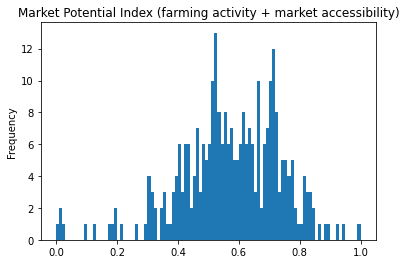

In [21]:
settl_point['mrkt_potential']=settl_point['access_farm_index_n']*0.6+settl_point['farming_activity_n']*0.4
#normalize
settl_point['mrkt_potential_n'] = scaler.fit_transform(settl_point['mrkt_potential'].values.reshape(-1, 1)).flatten()
settl_point['mrkt_potential_n'].plot.hist(bins=100, title='Market Potential Index (farming activity + market accessibility)')
settl_point.plot.scatter(y='mrkt_potential_n', x='farming_activity_n')
settl_point.plot.scatter(y='mrkt_potential_n', x='access_farm_index_n')

In [ ]:
settl_point['mrkt_potential_n'].describe()

Visualize the Market Potential Index

In [ ]:
#top_farming_mrkt_pot=settl_point.sort_values(by='mrkt_potential_n',ascending=False).head(1000)
settl_point['mrkt_potential_n'].describe()

top_farming_mrkt_pot=settl_point.loc[settl_point['mrkt_potential_n'] > .550311]
m=top_farming_mrkt_pot.explore(
    column='mrkt_potential_n',
    marker_kwds=dict(radius=2, fill=True),  # make marker radius 10px with fill
    style_kwds=dict(weight=0.5,opacity=0.2,fillOpacity=0.3),  # make line thickness 1px
    tooltip='mrkt_potential_n',
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB Positron",  # use "CartoDB positron" tiles
    cmap="viridis",  # use "Set1" matplotlib colormap
    labels=["Farming market potential"],
    legend_kwds=dict(caption='Farming market potential (farming activity + access to markets)'),
    location=[-15.92071047059695, 35.992526466359394],
    zoom_start=7,
    #style_kwds=dict(color="black"),  # use black outline
                tooltip_kwds={
        'style': 'font-size: 8px;'
    },
    popup_kwds={
        'style': 'font-size: 10px;'
    },
    height=1000
)
m
#top_farming_mrkt_pot.explore(tooltip=['mrkt_potential_n','access_farm_index_n','farming_activity_n'])

## Pending modules
- Crop-specific analysis, including insights on high-value crops or specific value chains
- Fish market potential
- Livestock market potential
- Climate risk indicators, for site selection based on climate adaptation needs
- More robust socio-economic indicator (currently based on Relative Wealth Index)
- More refined electrification status indicator, based on distance from MV lines and night ligthts (currently only based on night lights)

## Create multi-criteria selection tool (Beta)

In [ ]:
w=widgets.FloatRangeSlider(
    value=[0, 6],
    min=0, #settl_point['travel_to_airports'].min(),
    max=9, #settl_point['travel_to_airports'].max(),
    step=0.1,
    description='travel_to_airports',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

In [ ]:
w.value

In [ ]:
pn.extension()
slider_pop = pn.widgets.EditableRangeSlider(
    name='Population', start=0, end=2000000, value=(5000,80000),
    step=50)

slider_farm_act = pn.widgets.EditableRangeSlider(
    name='Farming activity index', start=0, end=1, value=(0.6,1),
    step=50)

slider_fish_act_marine = pn.widgets.EditableRangeSlider(
    name='Marine fishing activity index', start=0, end=1, value=(0.6,1),
    step=0.01)

slider_fish_act_inland = pn.widgets.EditableRangeSlider(
    name='Inland fishing activity index', start=0, end=1, value=(0.6,1),
    step=0.01)

checkbox_group_electr_mk = pn.pane.Markdown('Electrification status')
checkbox_group_electr = pn.widgets.CheckBoxGroup(
    name='Electrification', value=['Not electrified'], options=['Electrified', 'Likely electrified', 'Not electrified'],
    inline=True)

slider_dist_grid= pn.widgets.EditableRangeSlider(
    name='Distance from the grid MV lines (km)', start=0, end=1000, value=(0,1.5),
    step=0.1)

slider_pop_nearby= pn.widgets.EditableRangeSlider(
    name='Local market: population within 20 km radius', start=0, end=2700000, value=(0,2700000),
    step=50)

slider_tt_airport= pn.widgets.EditableRangeSlider(
    name='Travel time to airports (hr)', start=0, end=20, value=(0,5),
    step=0.1)

slider_tt_maj_city= pn.widgets.EditableRangeSlider(
    name='Travel time to major cities (hr)', start=0, end=20, value=(0,2),
    step=0.1)

slider_tt_railw= pn.widgets.EditableRangeSlider(
    name='Travel time to railway stations (hr)', start=0, end=20, value=(0,1),
    step=0.1)

slider_tt_port= pn.widgets.EditableRangeSlider(
    name='Travel time to ports (hr)', start=0, end=20, value=(0,2),
    step=0.1)

slider_tt_capital= pn.widgets.EditableRangeSlider(
    name='Travel time to Maputo (hr)', start=0, end=20, value=(0,6),
    step=0.1)

slider_poverty= pn.widgets.EditableRangeSlider(
    name='Poverty rate', start=0, end=1, value=(0.3,1),
    step=0.01)

slider_temp= pn.widgets.EditableRangeSlider(
    name='Average temperature', start=10, end=40, value=(22,35),
    step=0.1)

slider_CDD=pn.widgets.EditableRangeSlider(
    name='Cooling degree days @ 4C', start=4108, end=8413, value=(7000,8413),
    step=0.1)

slider_risk= pn.widgets.MultiChoice(
    name='Climate risk', value=['Low', 'Medium', 'High'] ,options=['Low', 'Medium', 'High'])

slider_solar= pn.widgets.MultiChoice(
    name='Solar irradiation (for solar-powered cold rooms)', value=['Low', 'Medium', 'High'] ,options=['Low', 'Medium', 'High'])

checkbox_group_produce = pn.widgets.MultiChoice(
    name='Producer of:',value=['banana',
'cassava',
'cowpea',
'other roots',
'plantain',
'potato',
'sweet potato',
'temperate fruit',
'tropical fruit',
'vegetables',
'yams',
'meat',
'fish',
],
    options=['banana',
'cassava',
'cowpea',
'other roots',
'plantain',
'potato',
'sweet potato',
'temperate fruit',
'tropical fruit',
'vegetables',
'yams',
'meat',
'fish',
],
   )

pn.config.sizing_mode='scale_both'
""" pane_inputs=pn.Column(
            slider_pop, 
          slider_farm_act,
          slider_fish_act_marine,
          slider_fish_act_inland,
          checkbox_group_electr_mk,
          checkbox_group_electr,
          checkbox_group_produce,
          slider_pop_nearby,
          slider_tt_airport,
          slider_tt_maj_city,
          slider_tt_railw,
          slider_tt_port,
          slider_tt_capital,
          slider_poverty,
          slider_risk,
          slider_solar
          ) """
          
pane_inputs=pn.Row(
    pn.layout.Divider(margin=0),
    pn.Column(
            '## Demographics ans socio-economic',
            slider_pop, 
            slider_poverty,
            "## Composite indicators",
          slider_farm_act,
          slider_fish_act_marine,
          slider_fish_act_inland,
          ".../n",
          "## Electrification",
          checkbox_group_electr_mk,
          checkbox_group_electr,
          slider_dist_grid,
          "## Productivity",
          "... production (tons) per produce",
          checkbox_group_produce),

    pn.layout.Divider(margin=(30,0,0,0)),
     pn.Column(
          "## Access to markets",
          slider_pop_nearby,
          slider_tt_airport,
          slider_tt_maj_city,
          slider_tt_railw,
          slider_tt_port,
          slider_tt_capital,
          "## Risks",
          slider_risk,
          "## Resources",
          slider_solar,
          "## Temperature / cooling needs",
          slider_temp,
          slider_CDD
          )
    )
pane_inputs

Save pane in HTML (optional)

In [ ]:
#pn.panel(pane_inputs).save('pane_3.html')

Export geopackage (optional)

In [ ]:
#settl_point.to_file('settl_point_farm_ind.gpkg', driver='GPKG')